# Project: Combating Subscriber Churn with Targeted Marketing

**AZ Watch** is a popular video streaming platform specialized in educational content, where creators publish online video tutorials and lessons about any topic, from speaking a new language to cooking to learning to play a musical instrument.

Their next goal is to leverage AI-driven solutions to analyze and make predictions about their subscribers and improve their marketing strategy around attracting new subscribers and retaining current ones. This project uses machine learning to predict subscribers likely to churn and find customer segments. This may help AZ Watch find interesting usage patterns to build subscriber personas in future marketing plans!

The `data/AZWatch_subscribers.csv` **dataset** contains information about subscribers and their status over the last year:

|Column name|Description|
|-----------|-----------|
|`subscriber_id`|The unique identifier of each subscriber user|
|`age_group`|The subscriber's age group|
|`engagement_time`|Average time (in minutes) spent by the subscriber per session|
|`engagement_frequency`|Average weekly number of times the subscriber logged in the platform (sessions) over a year period|
|`subscription_status`|Whether the user remained subscribed to the platform by the end of the year period (subscribed), or unsubscribed and terminated her/his services (churned)|

Carefully observe and analyze the features in the dataset, asking yourself if there are any **categorical attributes** requiring pre-processing?

# Import the necessary modules

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector as selector
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
from matplotlib import pyplot as plt

# Read the CSV file into a Pandas DataFrame

In [3]:
file_path = "data/AZWatch_subscribers.csv"
df = pd.read_csv(file_path)

# Explore the Dataframe

In this section, we will examine the structure of our dataset. Things like shape, data types, etc.. basically gaining a gneral understanding of the data we are working with.

In [4]:
# Display DataFrame shape
print(f"Shape of the DataFrame: {df.shape}")

# Display data types and null counts
display(pd.DataFrame({
    'Data Type': df.dtypes,
    'Null Count': df.isnull().sum()
}))

# Display duplicate rows if they exist
if not df[df.duplicated()].empty:
    print("Duplicate Rows Found:")
    display(duplicates)
else:
    print("No duplicate rows found.")

Shape of the DataFrame: (1000, 5)


,Data Type,Null Count
subscriber_id,int64,0
age_group,object,0
engagement_time,float64,0
engagement_frequency,int64,0
subscription_status,object,0


No duplicate rows found.


In [5]:
# Display first few rows
df.head()

,subscriber_id,age_group,engagement_time,engagement_frequency,subscription_status
0,14451,18-34,5.55,7,subscribed
1,18386,under 18,5.12,12,subscribed
2,12305,35 and over,4.25,4,churned
3,17546,18-34,8.54,15,subscribed
4,15399,18-34,12.12,20,subscribed


In [58]:
def draw_plots(data, clusters=None, figsize=(15, 5), engagement_y_ticks=range(0, 48, 5)):
    if clusters is None:
        clusters = [None]
    
    # Define color palettes
    age_group_colors = sns.color_palette('Set2', len(data['age_group'].unique()))
    subscription_status_colors = sns.color_palette('Set1', 2)
    age_group_colors_map = dict(zip(sorted(data['age_group'].unique()), age_group_colors))
    subscription_status_colors_map = dict(zip(['subscribed', 'churned'], subscription_status_colors))
    
    # Plot setup
    fig, axes = plt.subplots(len(clusters), 3, figsize=(figsize[0], figsize[1] * len(clusters)))
    if len(clusters) == 1:
        axes = [axes]
    
    for i, cluster_id in enumerate(clusters):
        cluster_data = data if cluster_id is None else data[data['cluster'] == cluster_id]
        title_prefix = "Overall" if cluster_id is None else f"Cluster {cluster_id}"
        
        # Box plot
        sns.boxplot(data=cluster_data[['engagement_time', 'engagement_frequency']], ax=axes[i][0])
        axes[i][0].set_title(f'{title_prefix} - Engagement Metrics')
        axes[i][0].set_yticks(engagement_y_ticks)
        axes[i][0].grid(axis='y', linestyle='--', alpha=0.7)
        
        # Age Group Pie Chart
        age_group_counts = cluster_data['age_group'].value_counts()
        axes[i][1].pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%', 
                       startangle=90, colors=[age_group_colors_map[age] for age in age_group_counts.index])
        axes[i][1].set_title(f'{title_prefix} - Age Group Distribution')
        
        # Subscription Status Pie Chart
        subscription_status_counts = cluster_data['subscription_status'].value_counts()
        axes[i][2].pie(subscription_status_counts, labels=subscription_status_counts.index, autopct='%1.1f%%', 
                       startangle=90, colors=[subscription_status_colors_map[status] for status in subscription_status_counts.index])
        axes[i][2].set_title(f'{title_prefix} - Subscription Status')
    
    plt.tight_layout()
    plt.show()

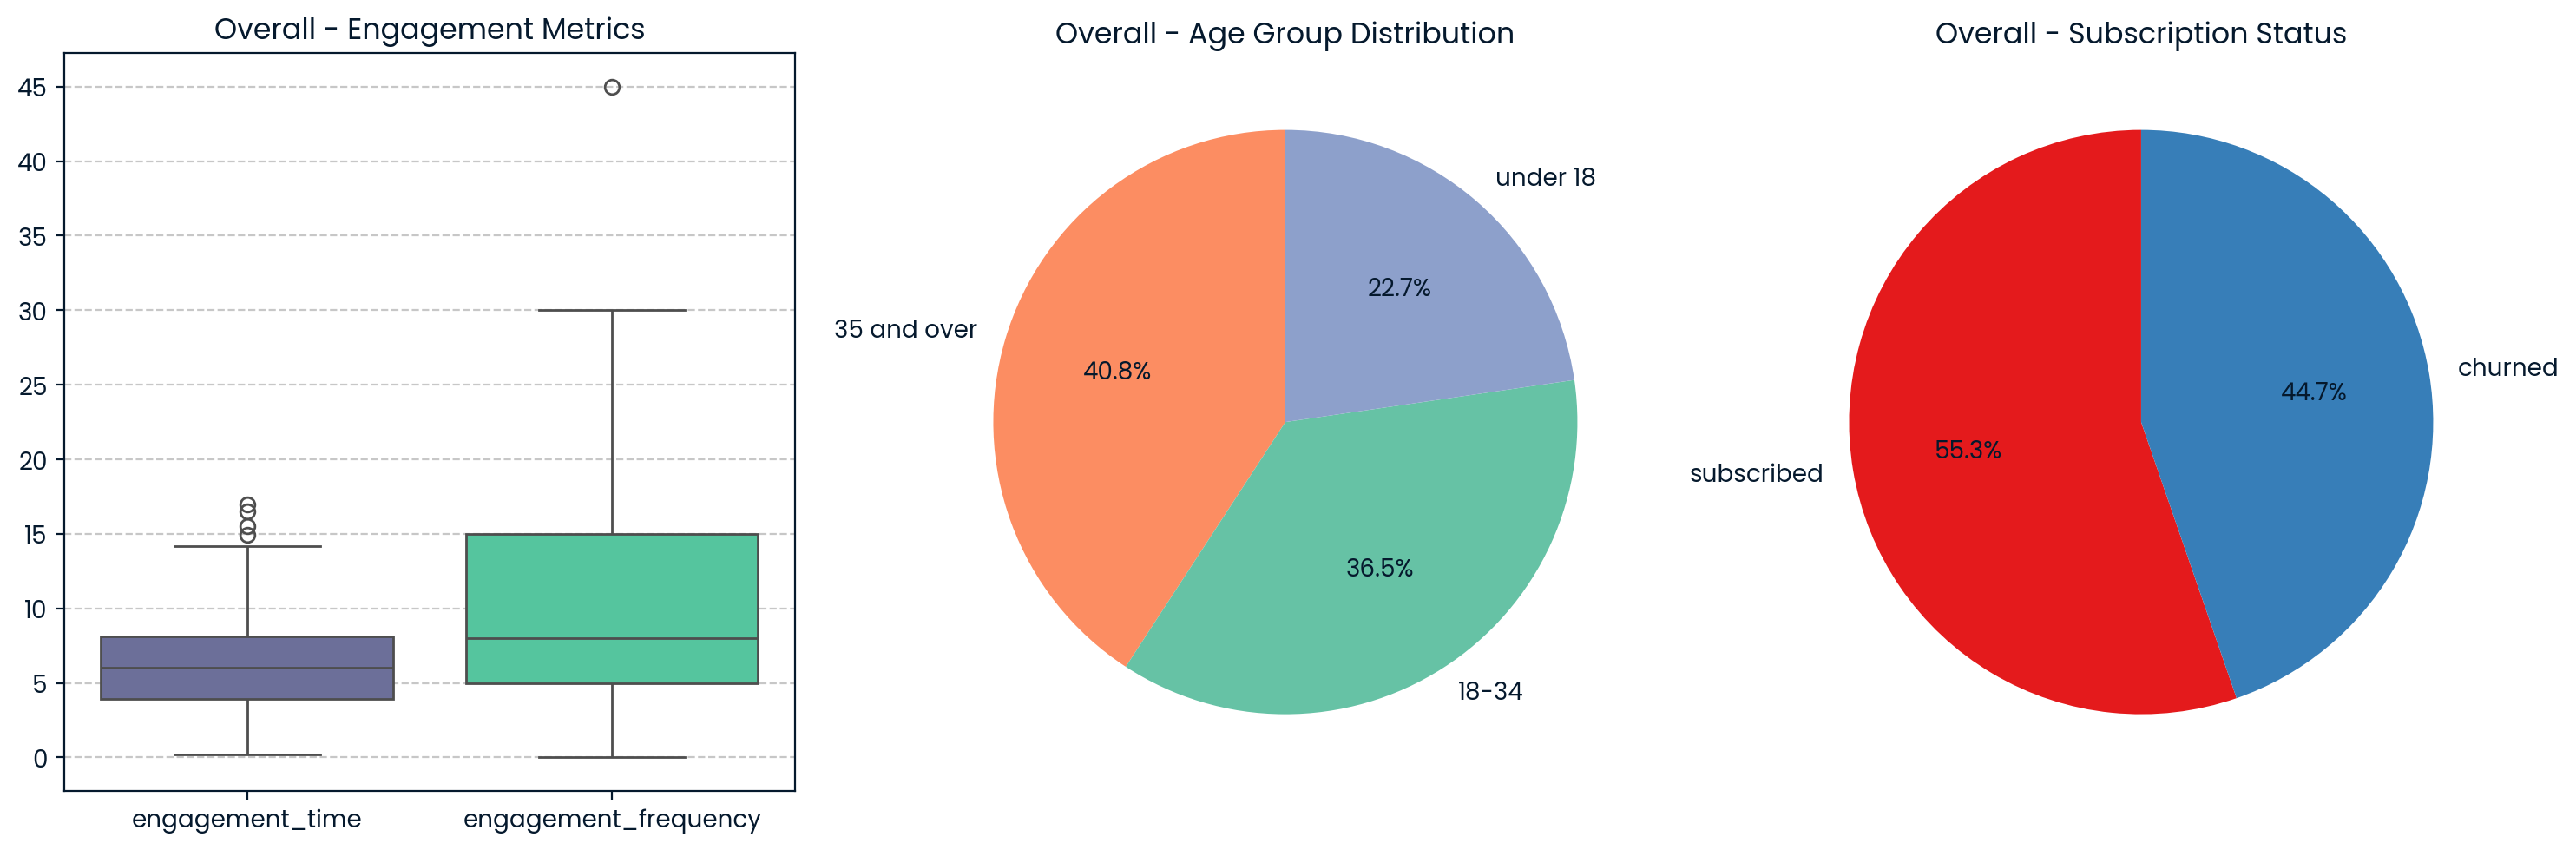

In [59]:
draw_plots(df)

# DataFrame Overview
The dataFrame contains two continuous numerical columns: `engagement_time` and `engagement_frequency` (excluding `subscriber_id` which will be dropped), along with one categorical column: `age_group`.  

For `engagement_time`, most data points are concentrated between **4** and **14** minutes, with a few extreme outliers above **14**, indicating occasional extreme usage.  

For `engagement_frequency`, the data shows a wider range, with a median of **8** sessions per week. No clear outliers, suggesting a more consistent but variable pattern of engagement.

Finally, the `age_group` column indicates a predominantly adult user base, with nearly 80% of users being over 18 years old.

In [6]:
# Separate predictor variables from class label

X = df.drop(['subscriber_id','subscription_status'], axis=1)
y = df.subscription_status

In [7]:
# Split data into 80% training and 20% testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Data Preprocessing
In this section, we will:
- Encode the `age_group` column into numerical values.
- Normalize `engagement_time` and `engagement_frequency` for consistent scaling.
- Encode `subscription_status` label into a binary format.

In [8]:
# Define selectors for numerical and categorical columns
num_cols_selector = selector(dtype_exclude=object)
cat_cols_selector = selector(dtype_include=object)

# Select numeric and categorical columns
num_cols = num_cols_selector(X_train)
cat_cols = cat_cols_selector(X_train)

In [9]:
# Define numerical and categorical preprocessors
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both preprocessors
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [10]:
# Binary encode the label column: 0 for 'subscribed' and 1 for 'churned'
y_train_processed = (y_train == 'churned').astype(int)
y_test_processed = (y_test == 'churned').astype(int)

# Train and Evaluate Different Classifiers

In this section, we compare three classifiers: `Logistic Regression`, `Decision Tree`, and `Random Forest`.

This process involves the use of metrics such as `Accuracy` and `Confusion Matrix`.

In [21]:
# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Function to plot confusion matrix
def plot_confusion_matrix(classifier_name, y_true, y_pred, ax):
    # Plot confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['Subscribed', 'Churned'], 
                yticklabels=['Subscribed', 'Churned'], ax=ax)
    
    # Set titles and labels
    ax.set_title(f"{classifier_name}\n( Accuracy: {accuracy:.2f} )")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Visualizing Metrics

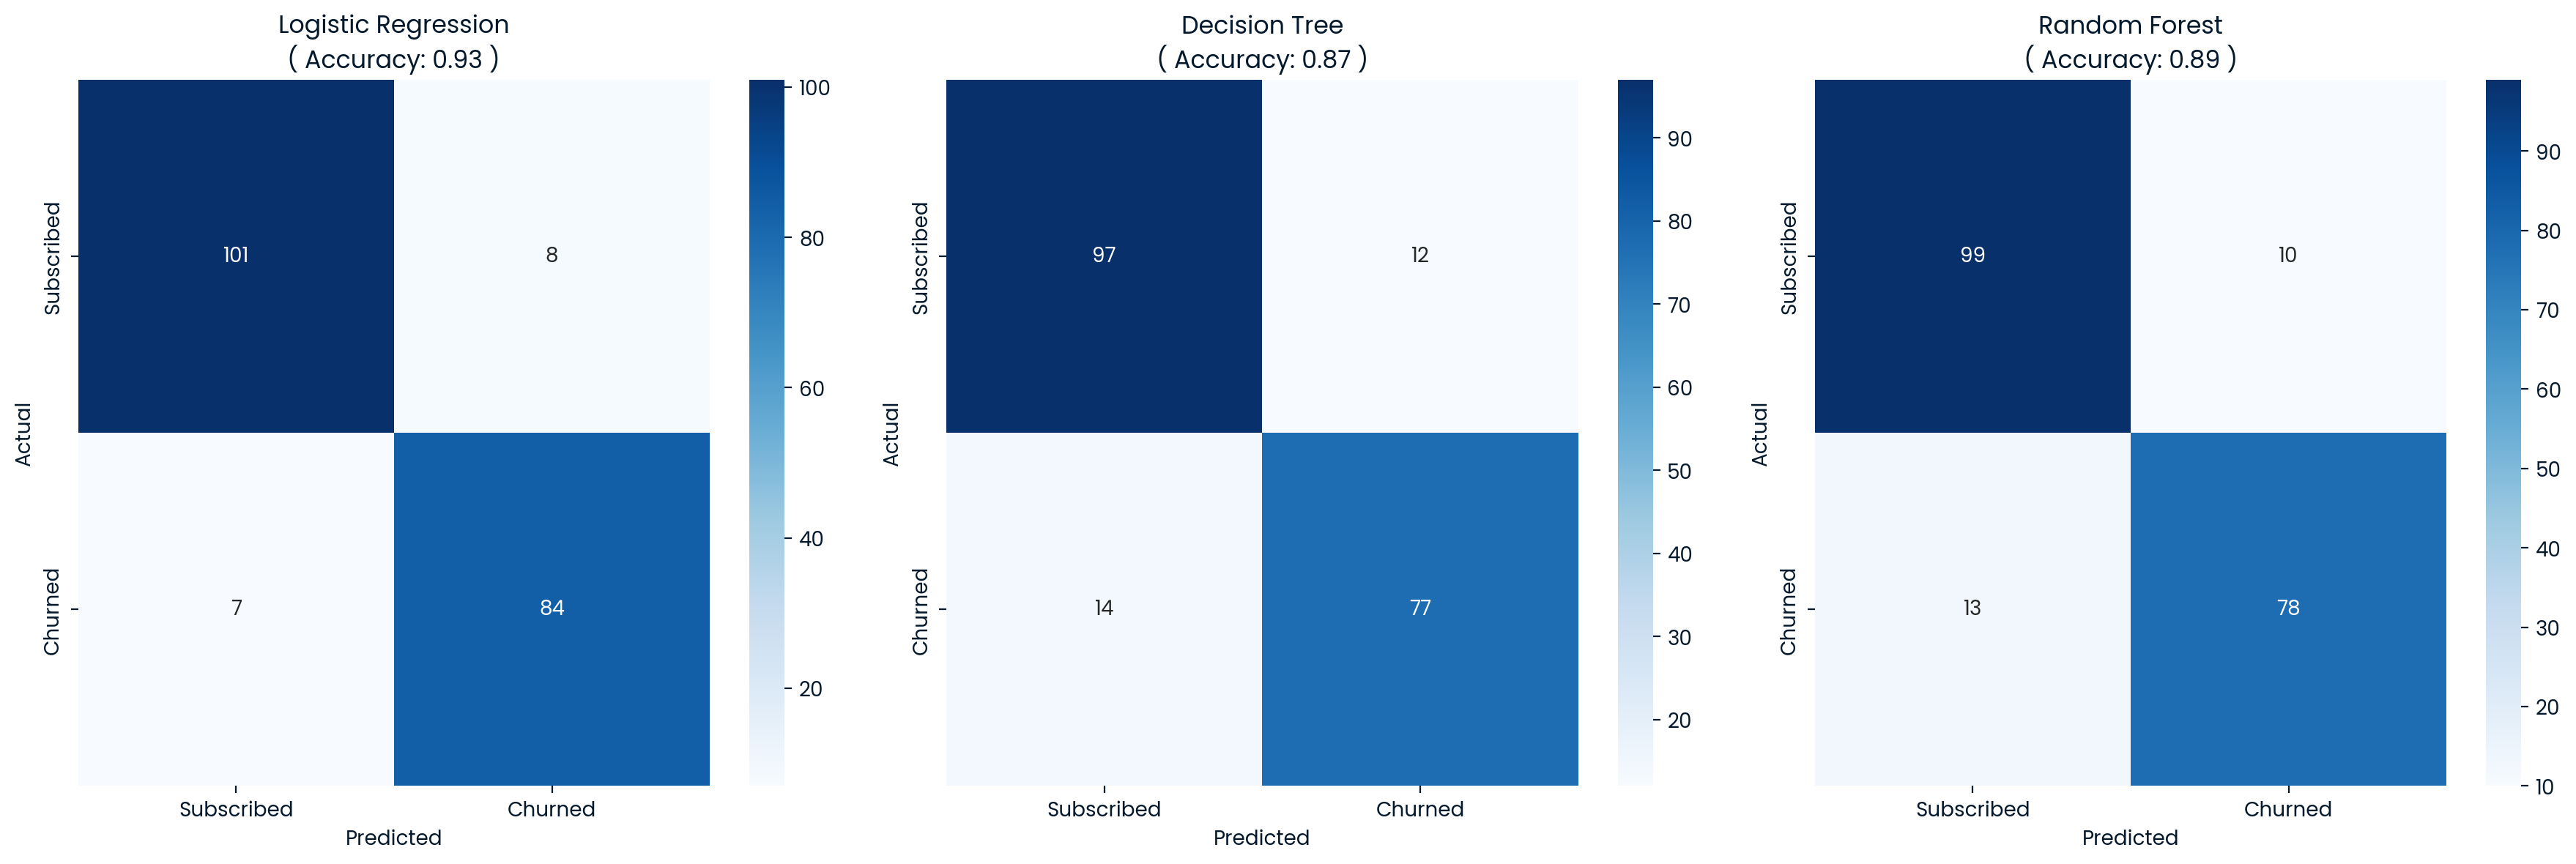

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Iterate over classifiers
for idx, (name, classifier) in enumerate(classifiers.items()):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Fit and predict
    pipeline.fit(X_train, y_train_processed)
    y_pred = pipeline.predict(X_test)
    
    # Compute accuracy and confusion matrix
    conf_matrix = confusion_matrix(y_test_processed, y_pred)
    accuracy = accuracy_score(y_test_processed, y_pred)
    
    # Plot
    plot_confusion_matrix(name, conf_matrix, accuracy, axes[idx])
    
plt.tight_layout()
plt.show()

# Clustering the User Base  
In this section, we’ll split the customers into seperate groups/clusters to make marketing easier and more targeted.

In [62]:
# Define and fit clustering model

X = preprocessor.fit_transform(df)
kmeans = KMeans(n_clusters=3, random_state=42) # After testing 2, 3, 4, and 5 clusters, 3 was found to be the most optimal.
kmeans.fit(X)

KMeans(n_clusters=3, random_state=42)

# Understanding Clusters through Visualization

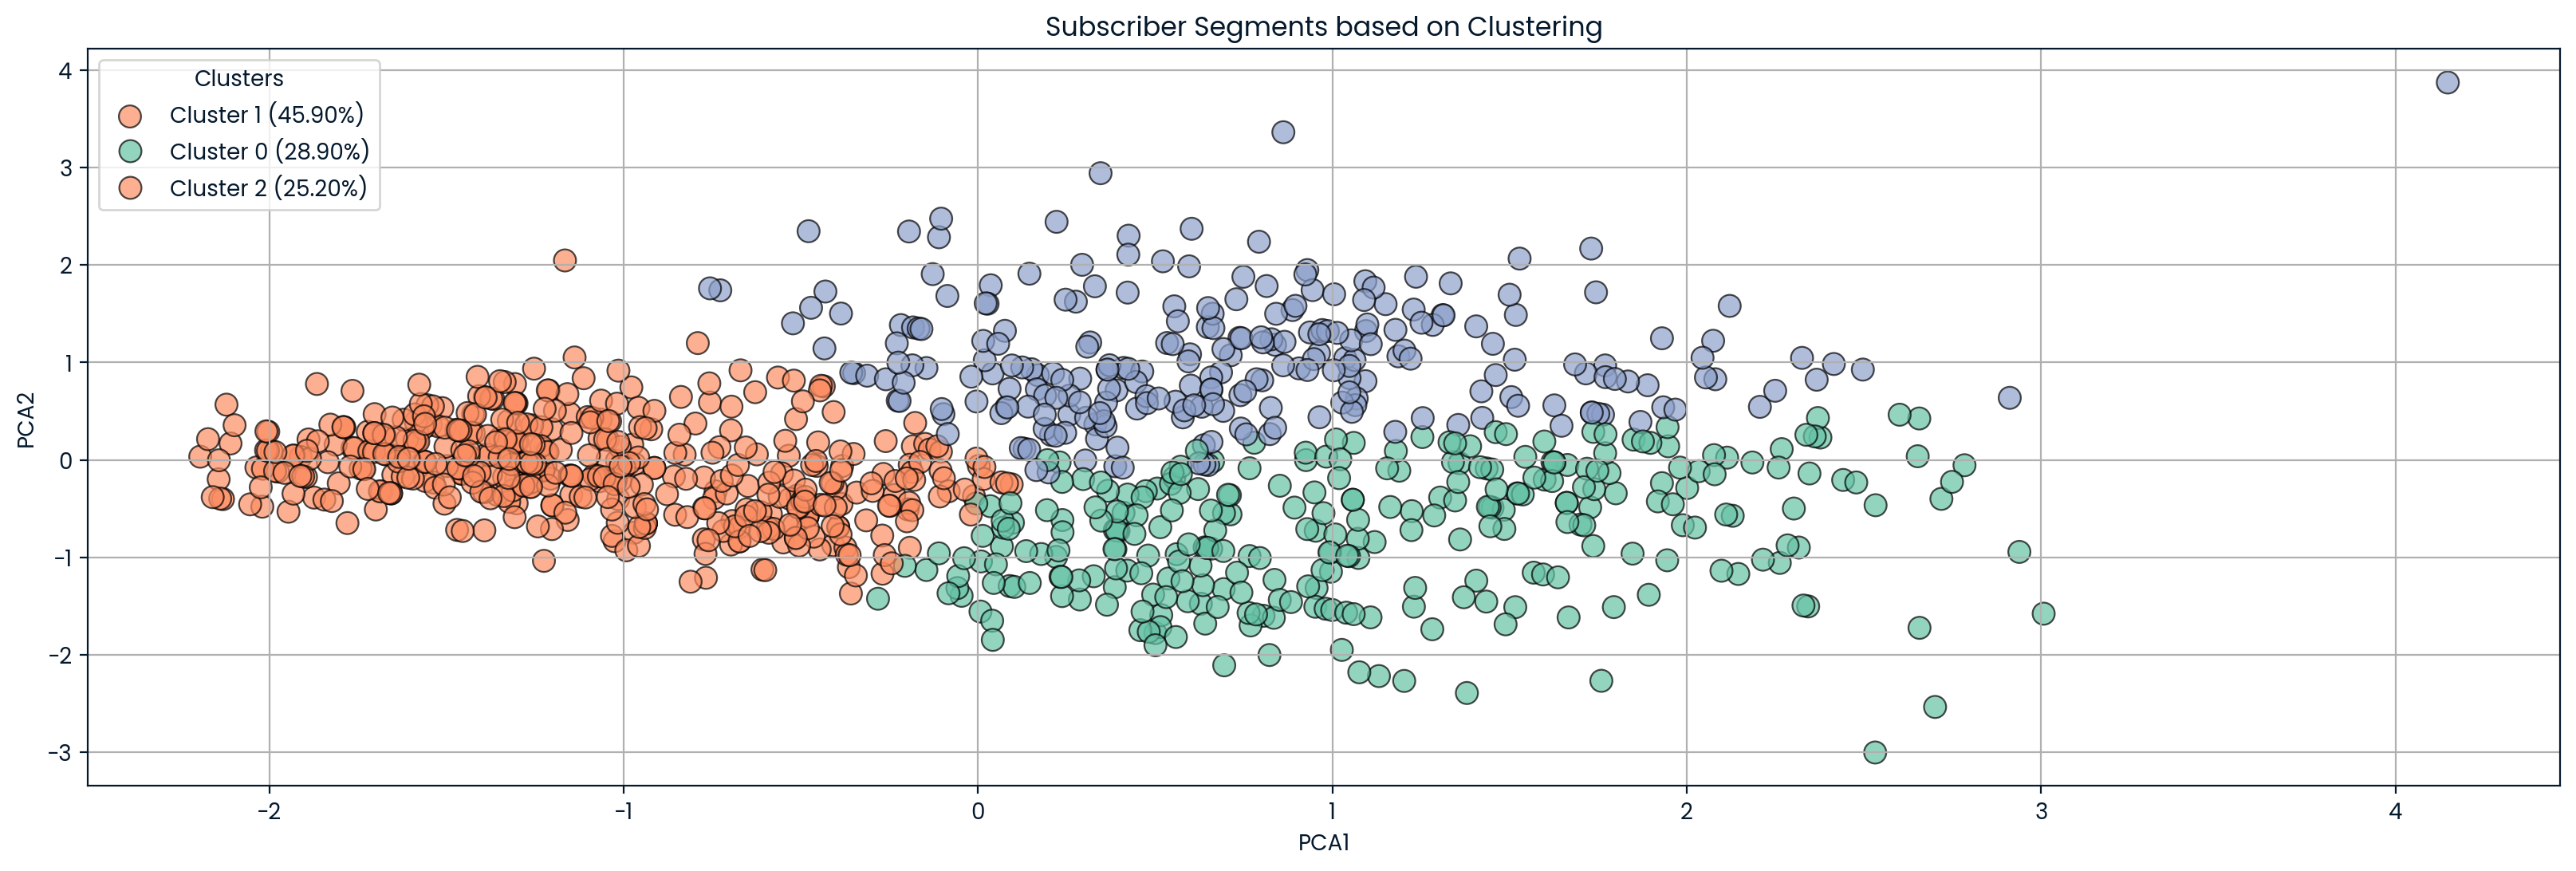

In [63]:
# Apply PCA and reduce dimensions to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Prepare legend labels 
cluster_percentages = df['cluster'].value_counts(normalize=True) * 100
legend_labels = [f'Cluster {cluster} ({cluster_percentages[cluster]:.2f}%)' for cluster in cluster_percentages.index]

# Create scatter plot
plt.figure(figsize=(20, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', palette='Set2', data=df, s=100, alpha=0.7, edgecolor='black')

# Set legend
plt.legend(title='Clusters', labels=legend_labels)

# Set plot title
plt.title('Subscriber Segments based on Clustering')
plt.grid(True)
plt.show()

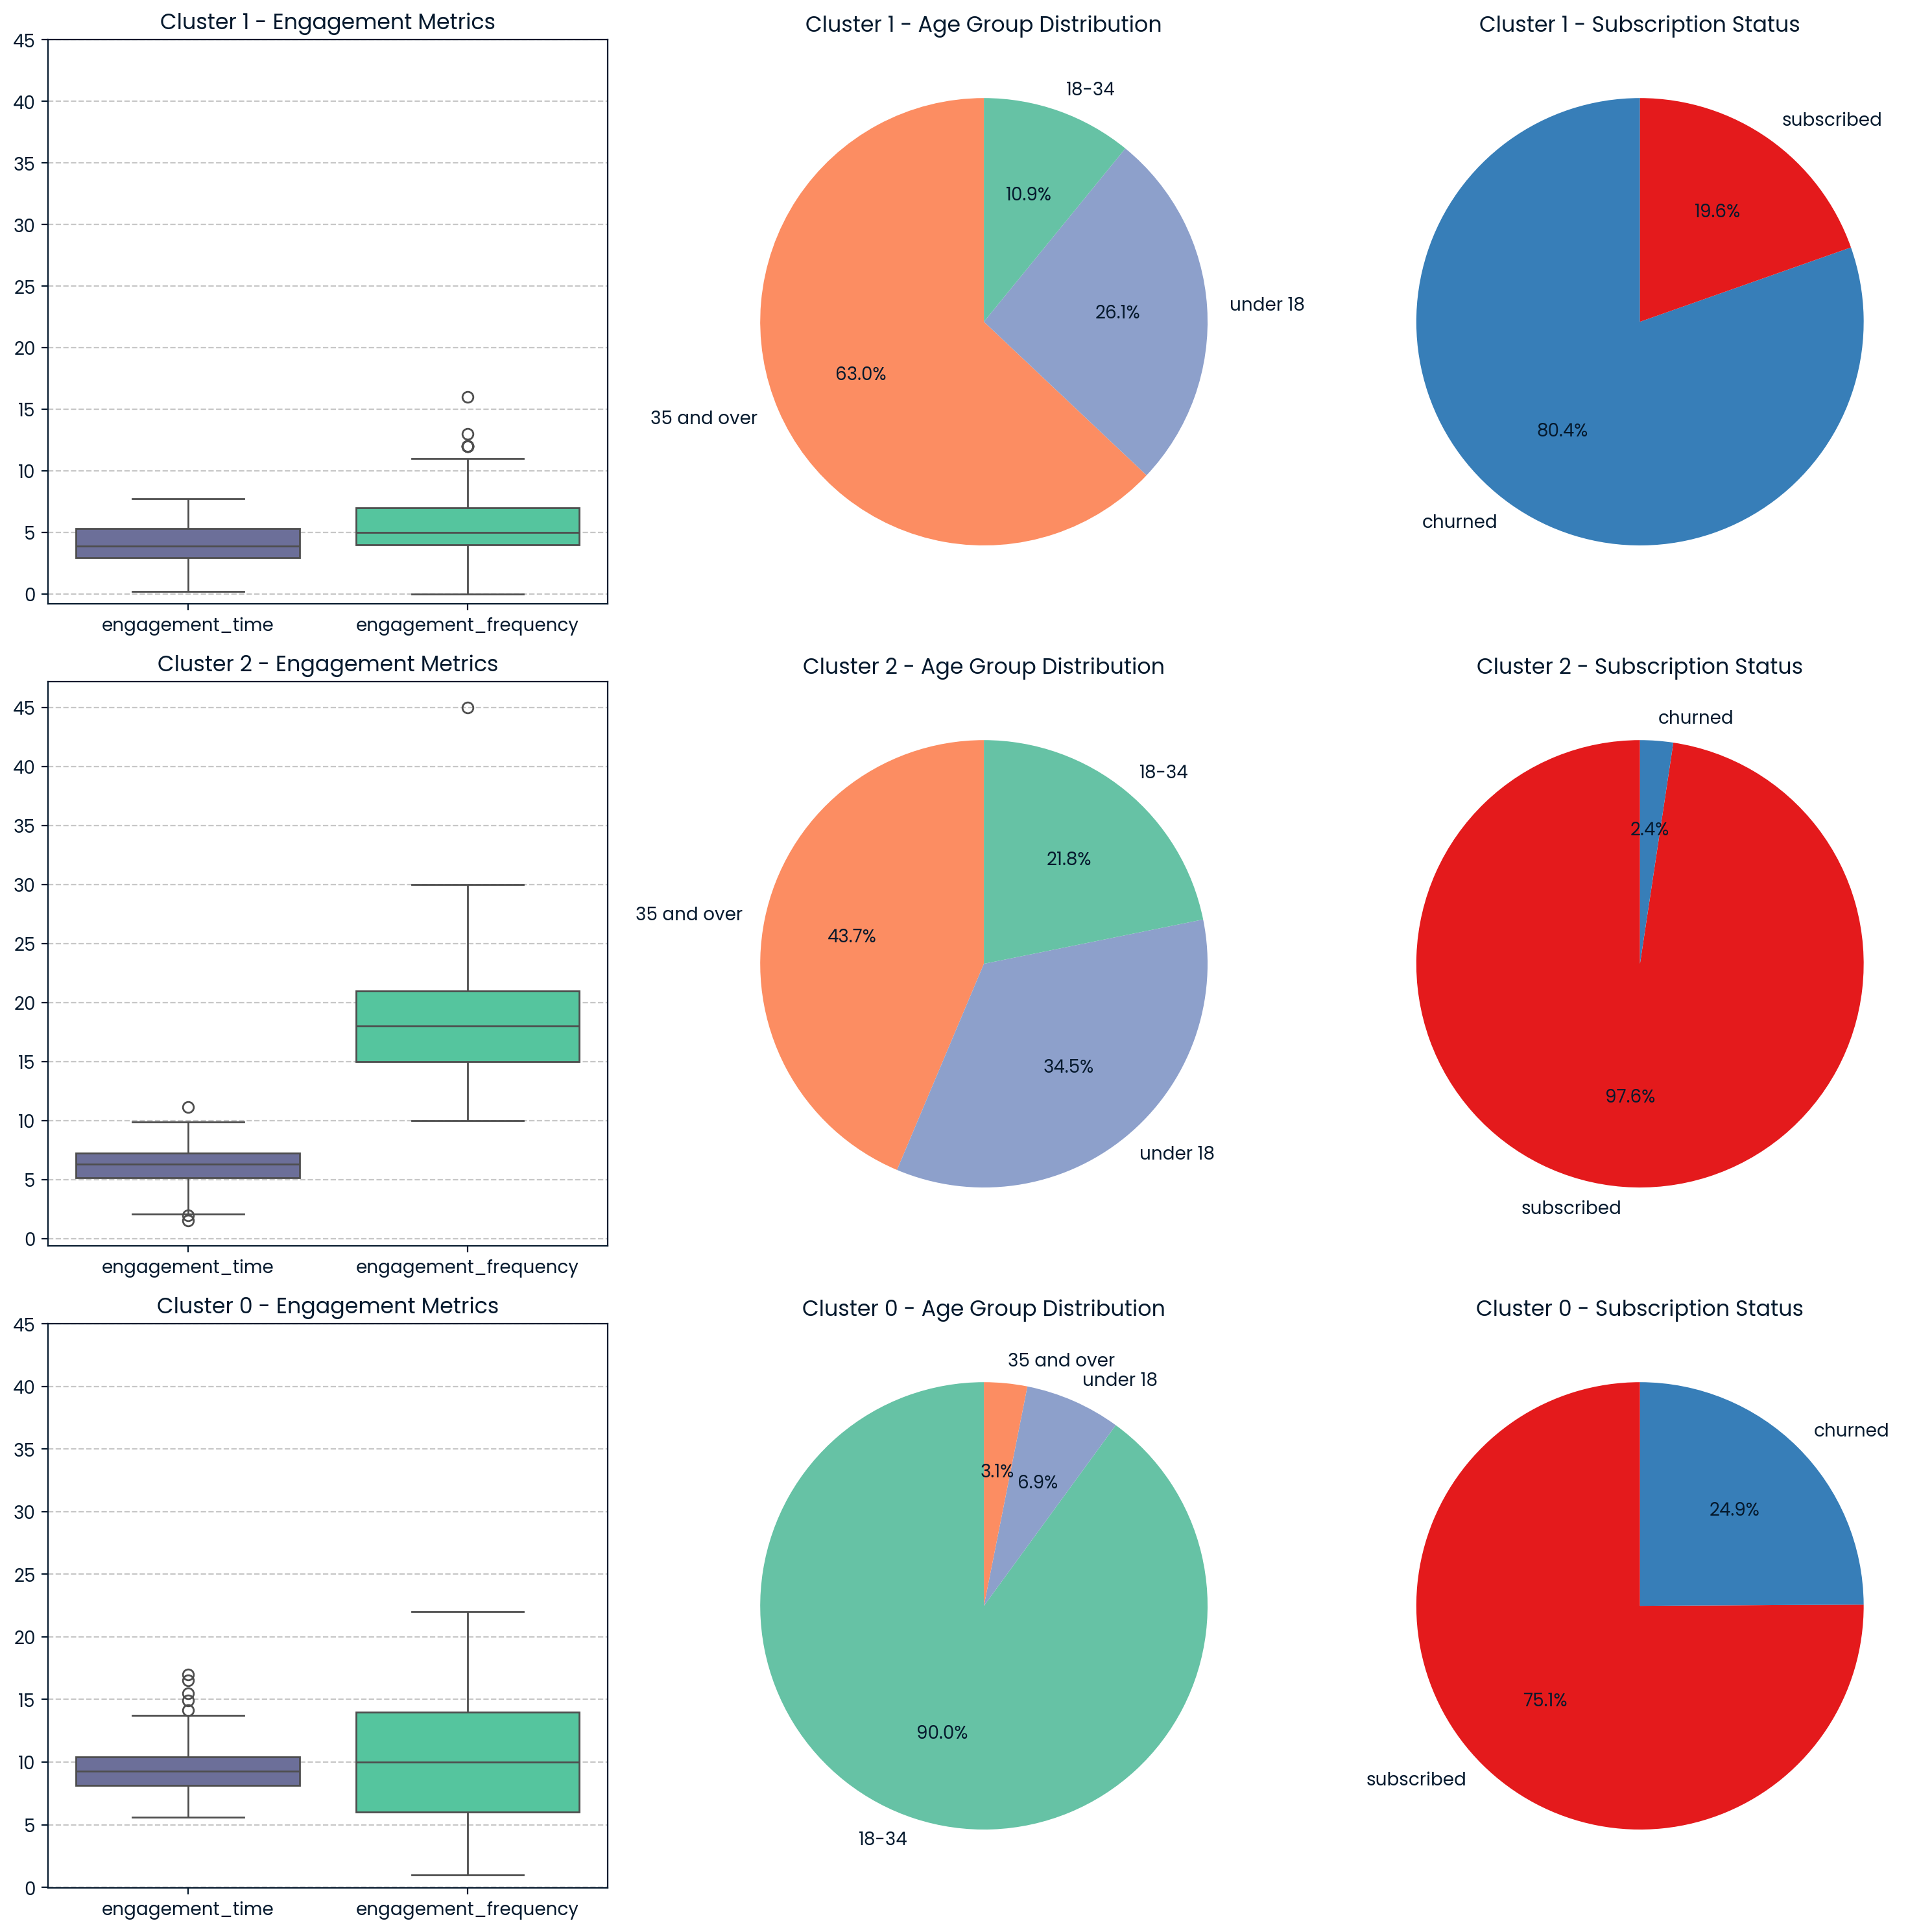

In [64]:
draw_plots(df, clusters=df['cluster'].unique(), figsize=(15, 5))

# Customer Clusters Summary
### Cluster 0: "Mostly Loyal, Engaged Customers" (28.9%)  
- The majority **(90%)** of this cluster is aged between **18–35** years.  
- They exhibit high engagement with an average of **~10 sessions per week** and **9–10 minutes per session**.  
- They have a **low churn rate** of **24.91%**.  

### Cluster 1: "Lowest Engagement, Highest Churn Customers" (45.9%)  
- This group appears older, with **63% aged 35+**, folowed by **26% under 18 years**.  
- Engagement is minimal, with **5 sessions per week** and an average session length of **4 minutes**.  
- They show the **highest churn rate** at **80%**.  

### Cluster 2: "Highly Engaged, Most Loyal Customers" (25.2%)  
- This cluster consists of a **diverse range of age groups**.  
- They demonstrate the **highest engagement frequency** with an average of **18 sessions** per week, and **5-7 minutes** per session.  
- Churn is at an exceptional low rate of just **2.4%**.  